In [1]:
import numpy as np
from sympy import *
from qiskit import *
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from numpy import linalg as la

In [2]:
Id = np.matrix([[1,0],[0,1]],dtype=complex)
X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)
Z = np.matrix([[1,0],[0,-1]],dtype=complex)

In [3]:
# The values used in our paper. 
a= -0.08496099317164885 
b= -0.8913449722923625 
c= 0.2653567873681286 
d= 0.5720506205204723

In [4]:
# The values used in our paper. 
c_i= -0.8453688208879107 
c_x= 0.006726766902514836 
c_y= -0.29354208134440296 
c_z= 0.18477436355081123

In [5]:
# The Hamiltonian. 
H = a*Id+b*X+c*Y+d*Z
print(H)

[[ 0.48708963+0.j         -0.89134497-0.26535679j]
 [-0.89134497+0.26535679j -0.65701161+0.j        ]]


In [6]:
# Find the exact eigenstates and eigenvalues. 
Awh, Avh = la.eig(H)
Aeval0h = float(re(Awh[0]))
Aeval1h = float(re(Awh[1]))
Aevec0h = Avh[:,0]
Aevec1h = Avh[:,1]
print('The energy eigenvalues of H are:',Aeval0h, 'and', Aeval1h)
print('The corresponding eigenvectors are:', '\n', Aevec0h,'\n', 'and','\n', Aevec1h)

The energy eigenvalues of H are: 1.0068961388154372 and -1.1768181251587344
The corresponding eigenvectors are: 
 [[ 0.87290447+0.j        ]
 [-0.46760946+0.13920912j]] 
 and 
 [[0.46760946+0.13920912j]
 [0.87290447+0.j        ]]


### Quantum Circuit

In [7]:
N = 3
Aevec0h1 = [0.8729044694074841+0j, -0.4676094626792474+0.13920911500783384j]

In [8]:
def qc1(E_targ,tstep,phi):                      
    
    ao = a + phi*c_i
    bo = b + phi*c_x
    co = c + phi*c_y
    do = d + phi*c_z
    
    sigo = Matrix([[bo],[co],[do]])
    n_hato = np.dot(1/sqrt(bo**2+co**2+do**2),sigo)
    nxo, nyo, nzo = [float(i.item()) for i in n_hato]    
    
    theta = 2*tstep*sqrt(bo**2+co**2+do**2) % (4*pi)   
    delta = float(re(atan(nzo*tan(theta/2))+atan(nxo/nyo)))
    beta = float(re(atan(nzo*tan(theta/2))-atan(nxo/nyo)))
    gamma = float(2*re(acos(cos(theta/2)/cos((delta+beta)/2)))) 
    if nyo > 0 and theta > 2*pi:
        gamma *= (-1)
    elif nyo < 0 and theta <= 2*pi:
        gamma *= (-1)   
    
    quanc1t = QuantumCircuit(2)
    quanc1t.h(1)
    quanc1t.cu(gamma,beta,delta,0,1,0)
    quanc1t.p(tstep*(E_targ-ao)-0.5*(delta+beta),1)               # The Energy Sensor.
    quanc1t.h(1) 
    quanc1t.barrier()
    return quanc1t

In [9]:
def qct(E_targ,sigma,phi):              
    qrz = QuantumRegister(2,'q')
    crz = ClassicalRegister(N,'c')
    qc = QuantumCircuit(qrz,crz)
    t = np.random.normal(0, sigma, N).tolist() 
    qc.initialize(Aevec0h1, 0)
    
    for i in range (N):
   #     sub_inst = qc1(E_targ,t[i],epsilon).to_instruction()
   #     qc.append(sub_inst,[obj,arena])
        qc.append(qc1(E_targ,t[i],phi),[0,1])   # 0:Obj, 1:Arena.
        qc.measure(1,i)    # Mid-circuit measurement, arena is measured. 
        qc.barrier()

 #   qc = transpile(qc,backend=backend,optimization_level=2,initial_layout = [obj,arena])
  #  qc = transpile(qc,backend=backend,optimization_level=2,layout_method = "noise_adaptive")
   # qc.barrier()
    return qc

### Noise Model

1. Depolarizing quantum channel: simulates the bit-flip and phase-flip errors that occur during operations due to gate fidelities within the circuit.

$$
\mathcal{E}(\rho) = \frac{pI}{2^n}\text{Tr}(\rho)+(1-p)\rho,\quad\text{where}
\quad\rho \equiv\sum_ip_i|\psi_i\rangle\langle\psi_i|.
$$


In [12]:
def depolarizing_noise(one_qubit_noise, two_qubit_noise):
    depolarizing_model = NoiseModel()
    error_1 = depolarizing_error(one_qubit_noise, 1)
    error_2 = depolarizing_error(two_qubit_noise, 2)
    depolarizing_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    depolarizing_model.add_all_qubit_quantum_error(error_2, ['cx'])
    print(depolarizing_model)
    return depolarizing_model

2. Amplitude and phase damping error:

### Noise model acts on a single-qubit circuit.

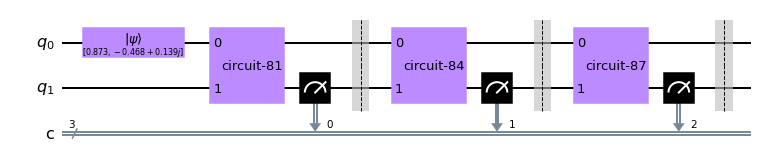

In [10]:
test_circuit = qct(Aeval0h,3,0)
test_circuit.draw('mpl')

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


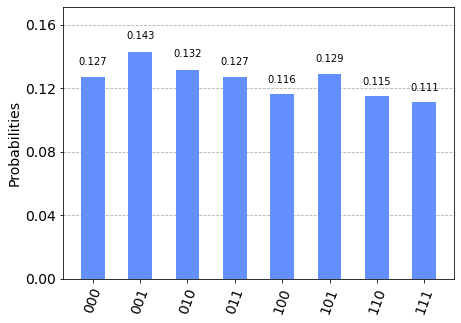

In [13]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model = depolarizing_noise(0.9,0.9))

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(test_circuit, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [ ]:
def numsli_expc (L,rang1,rang2,nuni,nshots,sigma,k,phi):   
    
    val0, val1,_,_,_,_ = H_obj(phi)
    EW = np.linspace(rang1,rang2,L)   # The energy spectrum we're interested in.
    circuits = []                     # The 'circuit matrix'. 
    
    for i in range(L):
        circuitsi = []
        for j in range (nuni):
            circuit =  qct(EW[i],sigma,phi)      
            circuitsi.append(circuit)
        circuits.append(circuitsi)
        
    all_circuits = []
    for i in range(L):
        all_circuits += circuits[i][:]
    
    
    MExperiments = job_manager.run(all_circuits, backend=backend, shots = nshots)
    results = MExperiments.results() 
      
  #  cresults = results.combine_results()             # We are not doing read-out error mitigation here.   
  #  mitigated_results = meas_filter.apply(cresults)
        
    probsu = []
    succs = '0'*N
    for i in range (L):
        probsui = []
        for j in range (nuni):
       #     counts = mitigated_results.get_counts((nuni*i)+j)
            counts = results.get_counts((nuni*i)+j)
            
            if succs in counts:
                prob = counts[succs]/sum(counts.values())
            else:
                prob = 0
            probsui.append(prob)
        probsu.append(np.average(probsui))
            
    spec = dict(zip(EW,probsu))
    
    
    plt.figure(figsize=(16.18,10)) 
    plt.xlabel(r'$Energy\ Spectrum\ (E_{target})$',fontsize = 15)
    plt.ylabel('Probability to measure the success state',fontsize = 15)
    hist = plt.bar(spec.keys(), spec.values(), width=np.abs((rang2-rang1)/L), color='lightseagreen',alpha = 0.7)  
    plt.legend([hist],['Results from qasm'])
    plt.grid()
    plt.show()
    
    # Weighted avg based on the highest bins. 
    #Larg = dict(sorted(spec.items(), key = itemgetter(1), reverse = True)[:Hisk])
    #Wavg = np.average(list(Larg.keys()), weights=list(Larg.values()))
    
    # Weighted avg of the highest consecutive bins. 
    keys = np.fromiter(spec.keys(), float, count=len(spec))
    vals = np.fromiter(spec.values(), float, count=len(spec))
    idx = np.convolve(vals, np.ones(k), 'valid').argmax()
    Wavg = np.average(keys[idx:idx + k], weights=vals[idx:idx + k])
    
    print('Range for the next scan', keys[idx:idx + k])
    print('The estimated Eigenvalue is', Wavg)
    print('The precise values are',val0,'and',val1)
    return spec